In [0]:
!pip install tensorflow-gpu
!pip install gdown

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
import joblib

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Feature scaling

In [0]:
data = pd.DataFrame({
    'Normal': np.random.normal(100, 50, 1000),
    'Exponential': np.random.exponential(25, 1000),
    'Uniform': np.random.uniform(-250, -50, 1000)
})

In [0]:
def plot_scaling_result(data, scaled_data, scaling_title, x_lim=(-5, 5)):

  scaled_df = pd.DataFrame(
      scaled_data, 
      columns=['Normal', 'Exponential', 'Uniform']
  )

  fig, (ax1, ax2) = plt.subplots(ncols=2)
  ax1.set_xlim((-300, 300))
  ax1.set_title('No Scaling')
  sns.kdeplot(data.Normal, ax=ax1)
  sns.kdeplot(data.Exponential, ax=ax1)
  sns.kdeplot(data.Uniform, ax=ax1)

  ax2.set_xlim(x_lim)
  ax2.set_title(scaling_title)
  sns.kdeplot(scaled_df.Normal, ax=ax2)
  sns.kdeplot(scaled_df.Exponential, ax=ax2)
  sns.kdeplot(scaled_df.Uniform, ax=ax2);

## Min-Max Scaling

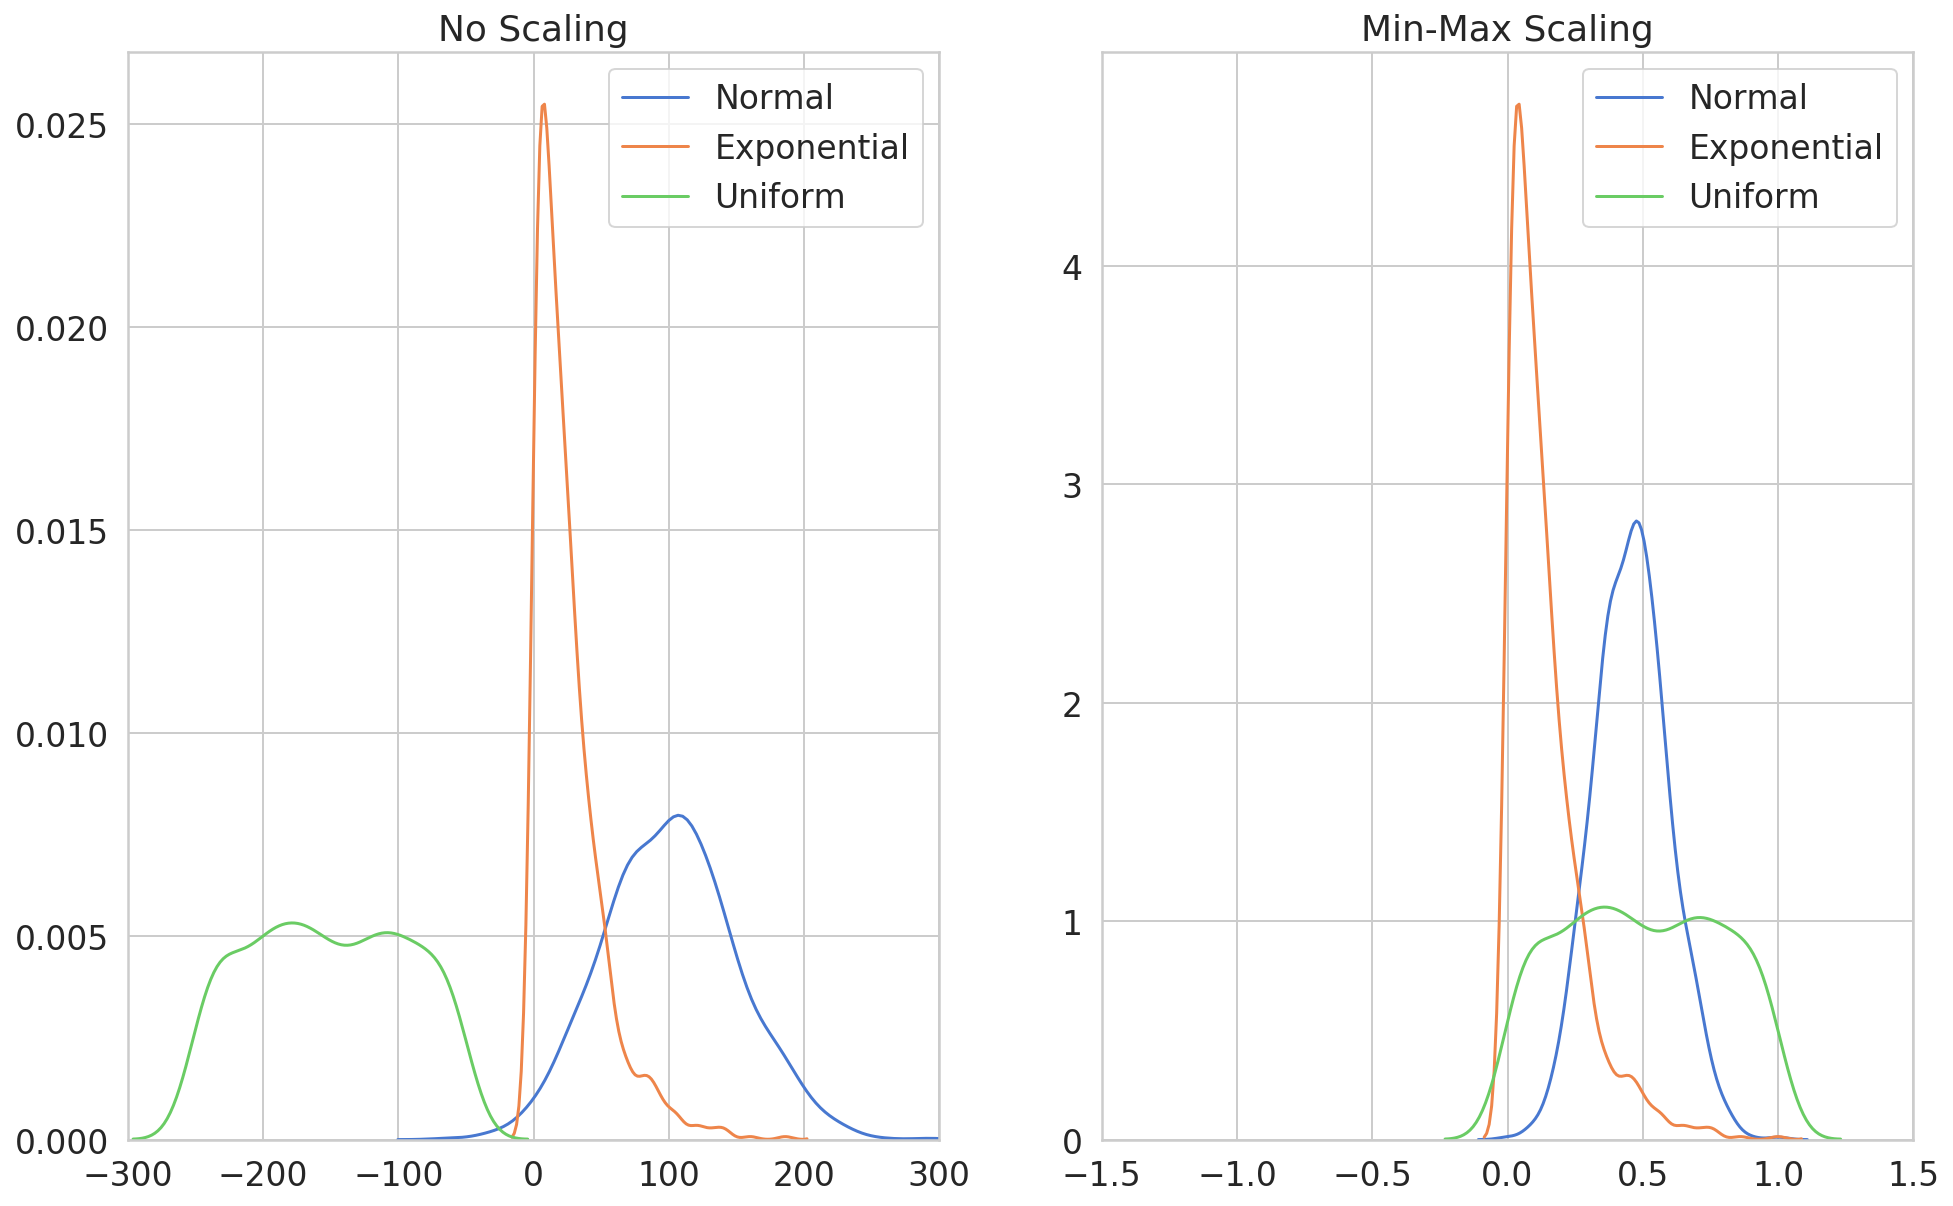

In [0]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(data)

plot_scaling_result(data, min_max_scaled, 'Min-Max Scaling', (-1.5, 1.5))

## Standardization

In [0]:
from sklearn.preprocessing import StandardScaler

stand_scaled = StandardScaler().fit_transform(data)

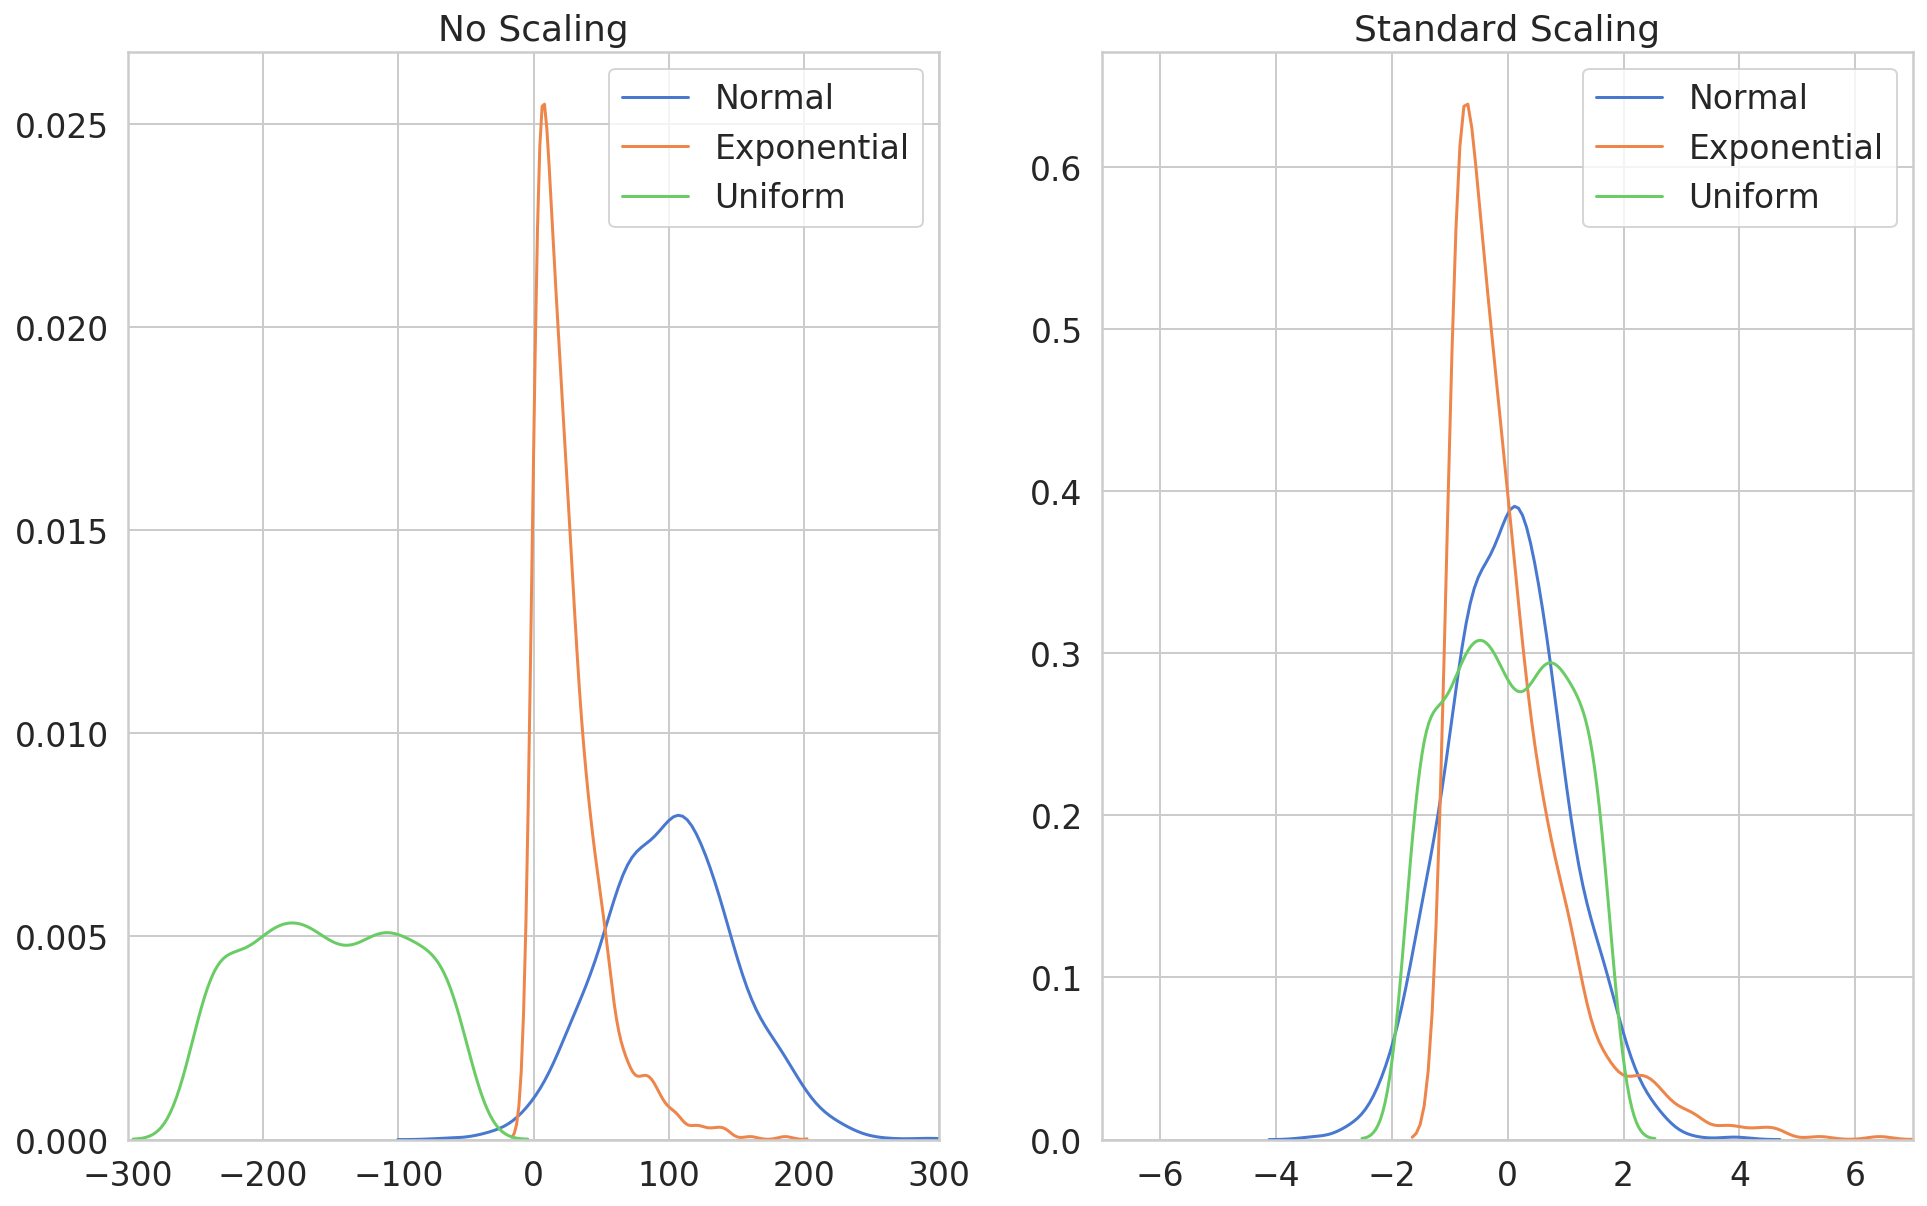

In [0]:
plot_scaling_result(data, stand_scaled, 'Standard Scaling', (-7, 7))

## Robust Scaling

In [0]:
from sklearn.preprocessing import RobustScaler

robust_scaled = RobustScaler().fit_transform(data)

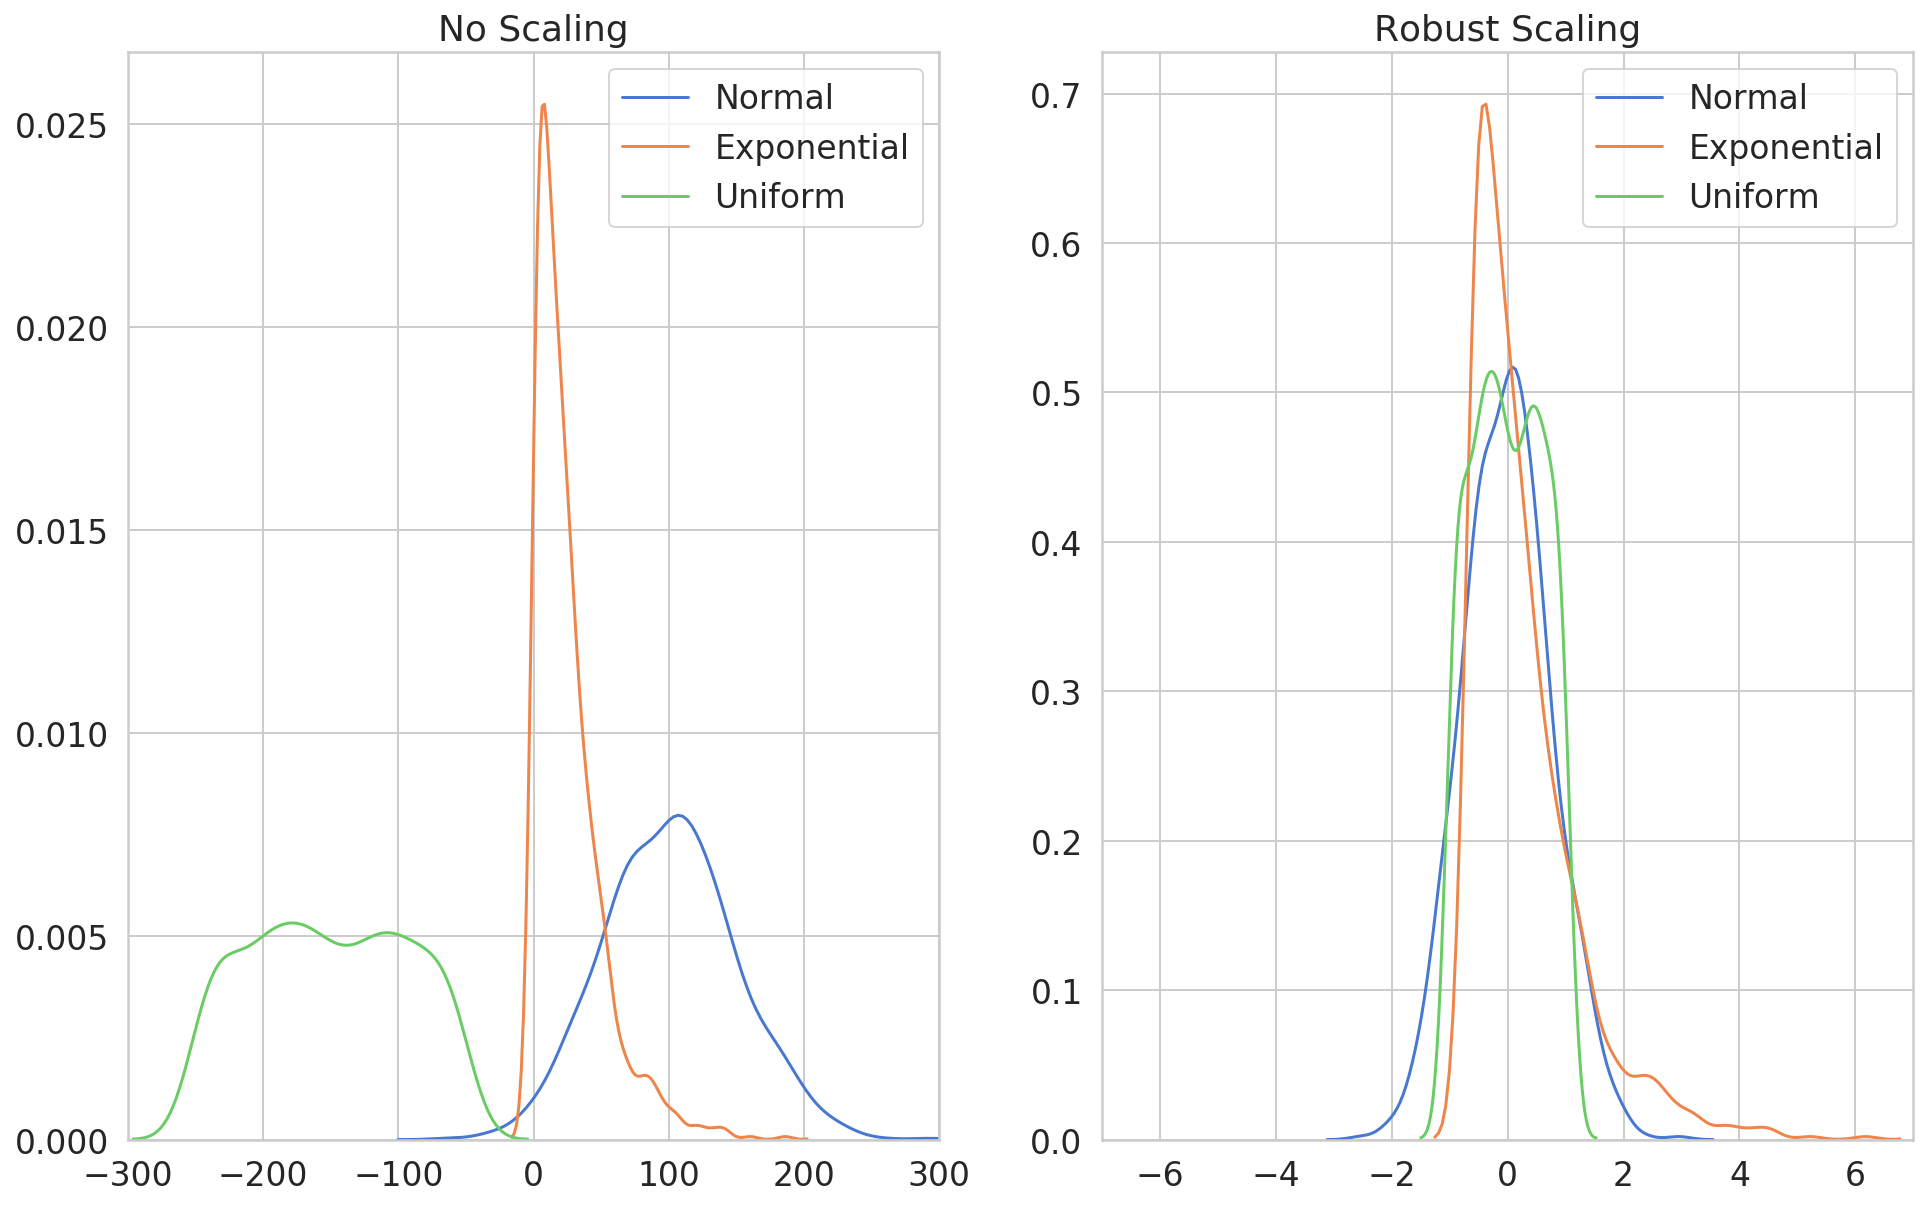

In [0]:
plot_scaling_result(data, robust_scaled, 'Robust Scaling', (-7, 7))

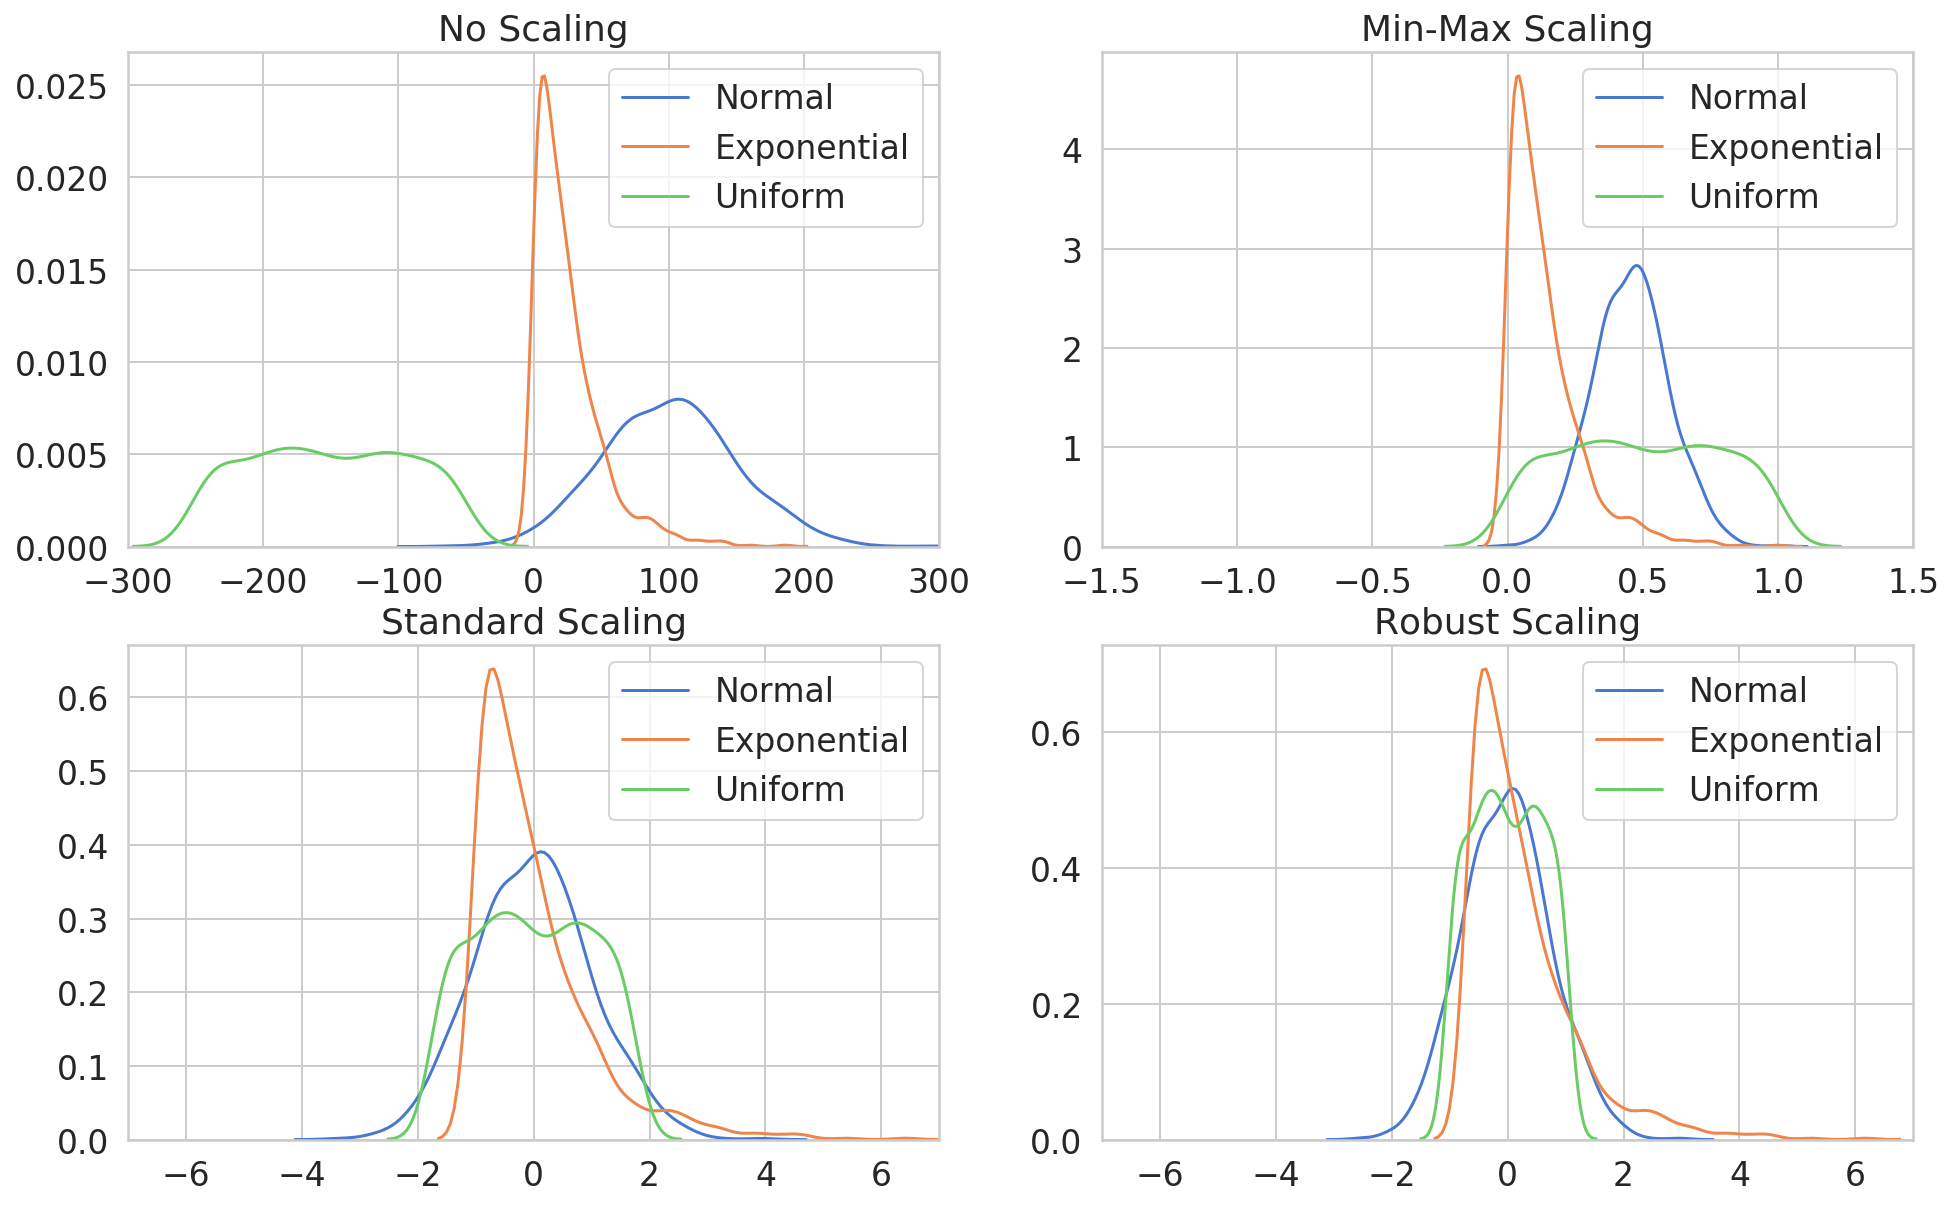

In [0]:
def plot_scaling(scaled_data, title, x_lim, ax):
  scaled_df = pd.DataFrame(
      scaled_data, 
      columns=['Normal', 'Exponential', 'Uniform']
  )

  ax.set_xlim(x_lim)
  ax.set_title(title)
  sns.kdeplot(scaled_df.Normal, ax=ax)
  sns.kdeplot(scaled_df.Exponential, ax=ax)
  sns.kdeplot(scaled_df.Uniform, ax=ax);

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
ax1.set_xlim((-300, 300))
ax1.set_title('No Scaling')
sns.kdeplot(data.Normal, ax=ax1)
sns.kdeplot(data.Exponential, ax=ax1)
sns.kdeplot(data.Uniform, ax=ax1)

plot_scaling(min_max_scaled, "Min-Max Scaling", (-1.5, 1.5), ax2)
plot_scaling(stand_scaled, "Standard Scaling", (-7, 7), ax3)
plot_scaling(robust_scaled, 'Robust Scaling', (-7, 7), ax4)

# Categorical Data

In [0]:
property_type = np.array(['House', 'Unit', 'Townhouse', 'House', 'Unit']).reshape(-1, 1)

## Integer encoding

In [0]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder().fit(property_type)
labels = enc.transform(property_type)
labels.flatten()

array([0., 2., 1., 0., 2.])

In [0]:
enc.inverse_transform(labels).flatten()

array(['House', 'Unit', 'Townhouse', 'House', 'Unit'], dtype='<U9')

## One Hot Encoding

In [0]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False).fit(property_type)
one_hots = enc.transform(property_type)
one_hots

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [0]:
enc.inverse_transform(one_hots).flatten()

array(['House', 'Unit', 'Townhouse', 'House', 'Unit'], dtype='<U9')

# Feature Engineering

## Binning

In [0]:
n_rooms = np.array([1, 2, 1, 4, 6, 7, 12, 20])

In [0]:
pd.cut(n_rooms, bins=[0, 3, 8, 100], labels=["small", "medium", "large"])

[small, small, small, medium, medium, medium, large, large]
Categories (3, object): [small < medium < large]

## Dates

In [0]:
dates = pd.Series(["1/04/2017", "2/04/2017", "3/04/2017"])

In [0]:
pd_dates = pd.to_datetime(dates)
pd_dates.dt.dayofweek

0    2
1    5
2    5
dtype: int64

# Predicting Melbourne Housing Prices

# Data

Data from Kaggle: https://www.kaggle.com/anthonypino/melbourne-housing-market/

In [0]:
!gdown --id 1bIa7HOtpakl1Qzn6pmKCMAzrWjM08mfI --output melbourne_housing.csv

Downloading...
From: https://drive.google.com/uc?id=1bIa7HOtpakl1Qzn6pmKCMAzrWjM08mfI
To: /content/melbourne_housing.csv
5.02MB [00:00, 157MB/s]


In [0]:
df = pd.read_csv('melbourne_housing.csv')

In [0]:
df.shape

(34857, 21)

In [0]:
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,2.0,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,3.0,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


In [0]:
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

BuildingArea     21115
YearBuilt        19306
Landsize         11810
Car               8728
Bathroom          8226
Bedroom2          8217
Longtitude        7976
Lattitude         7976
Price             7610
Propertycount        3
Regionname           3
CouncilArea          3
Postcode             1
Distance             1
dtype: int64

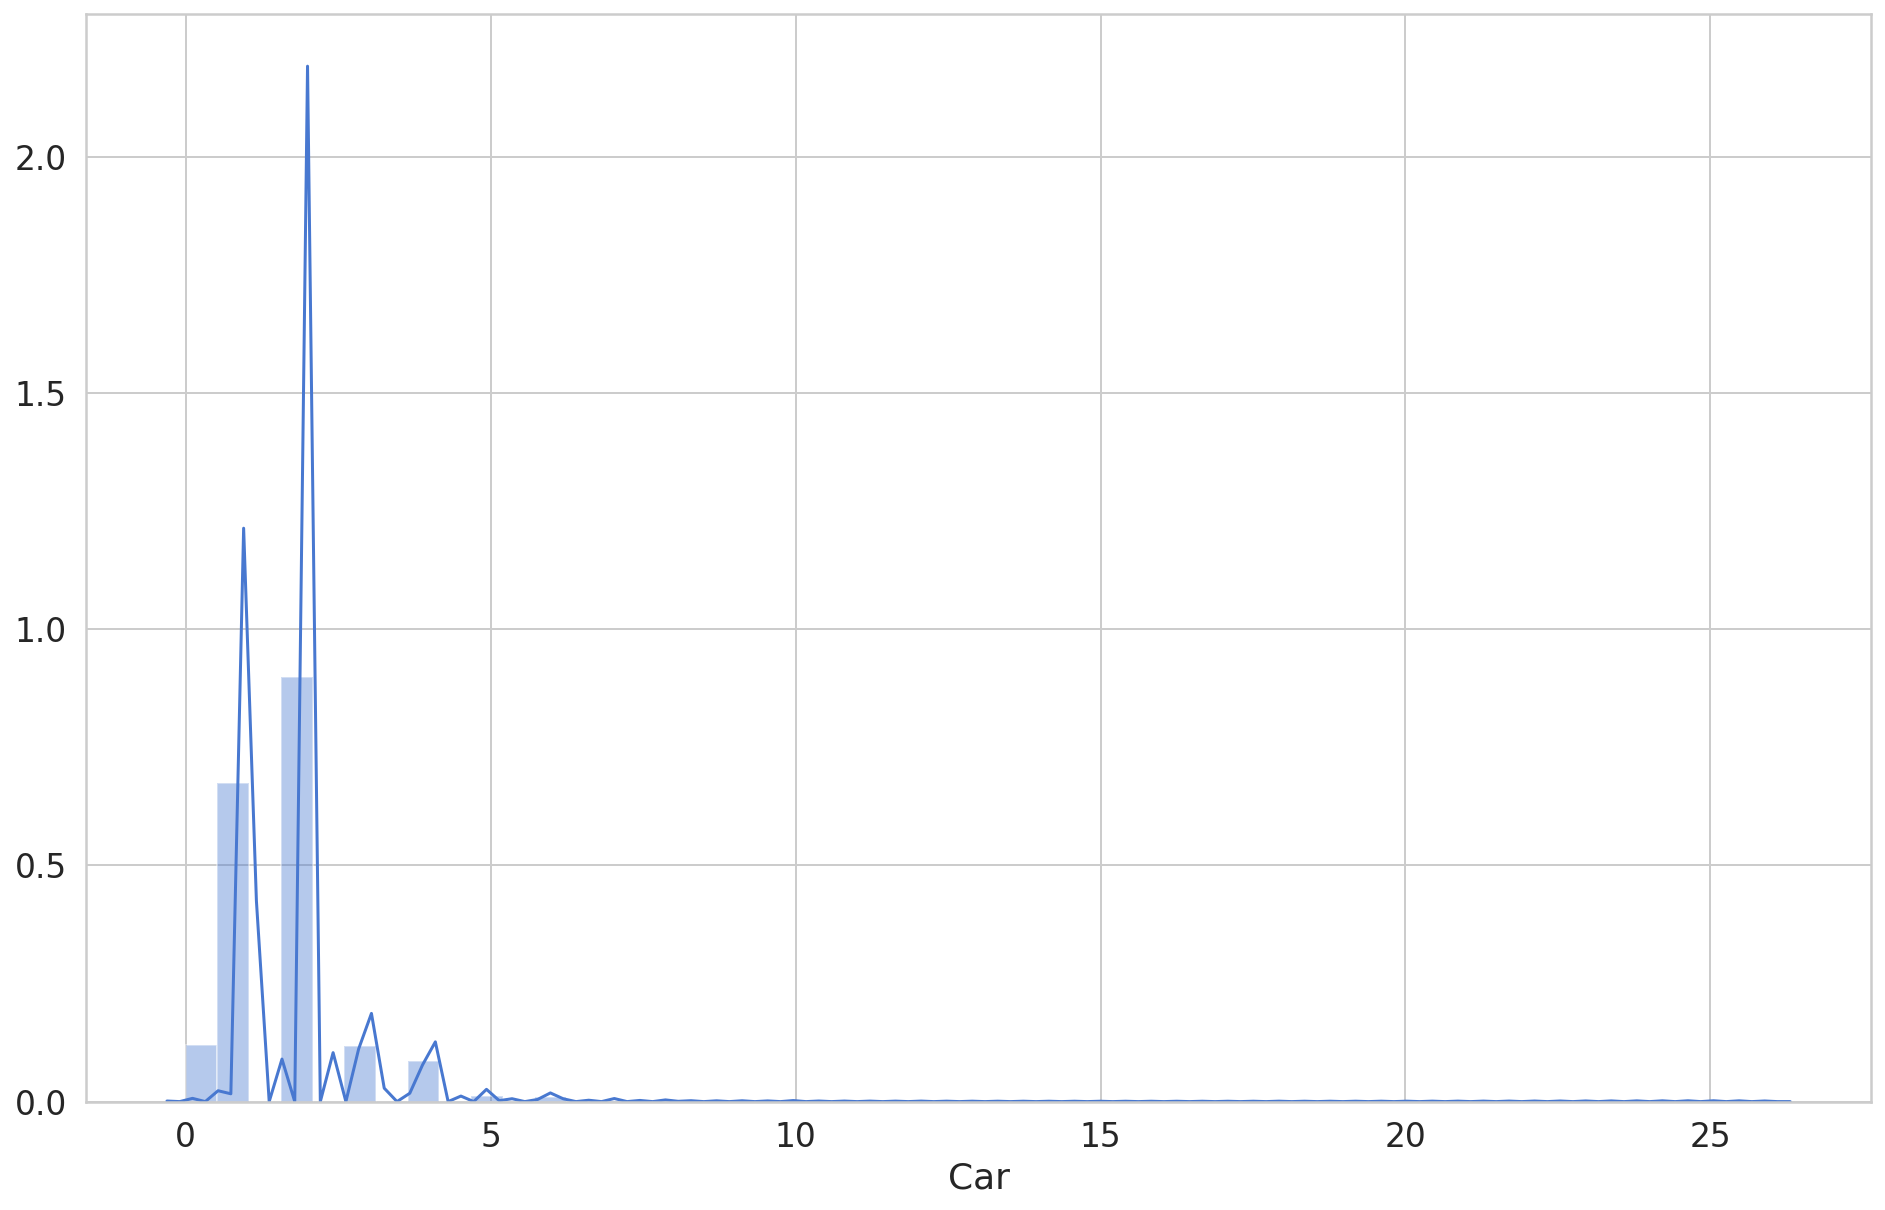

In [0]:
sns.distplot(df.Car.dropna());

In [0]:
df.Rooms.value_counts()

3     15084
2      8332
4      7956
5      1737
1      1479
6       204
7        32
8        19
10        6
9         4
12        3
16        1
Name: Rooms, dtype: int64

In [0]:
df = df.dropna()

In [0]:
df['Date'] = pd.to_datetime(df.Date)

In [0]:
df['SaleDayOfWeek'] = df.Date.dt.dayofweek

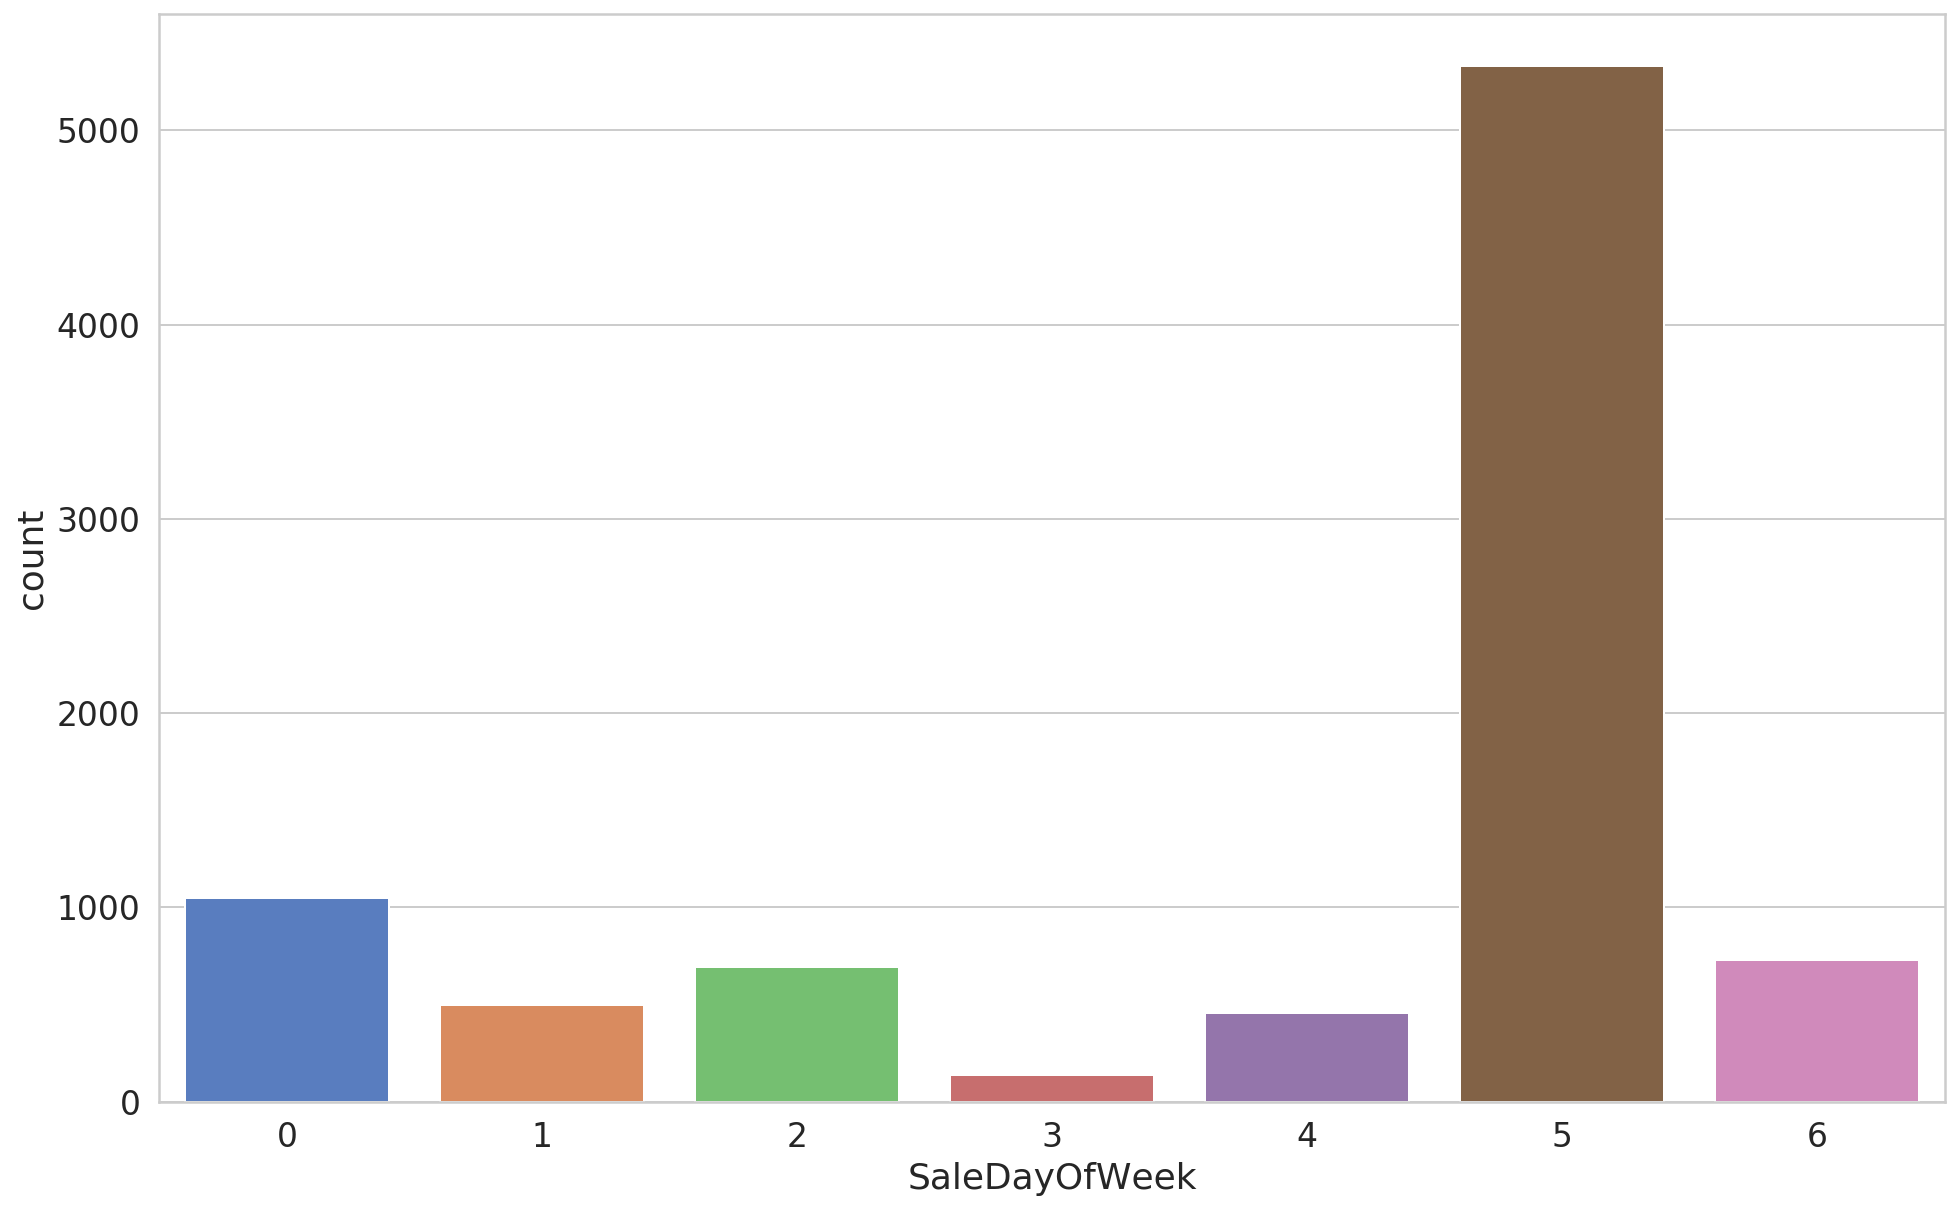

In [0]:
sns.countplot(df.SaleDayOfWeek);

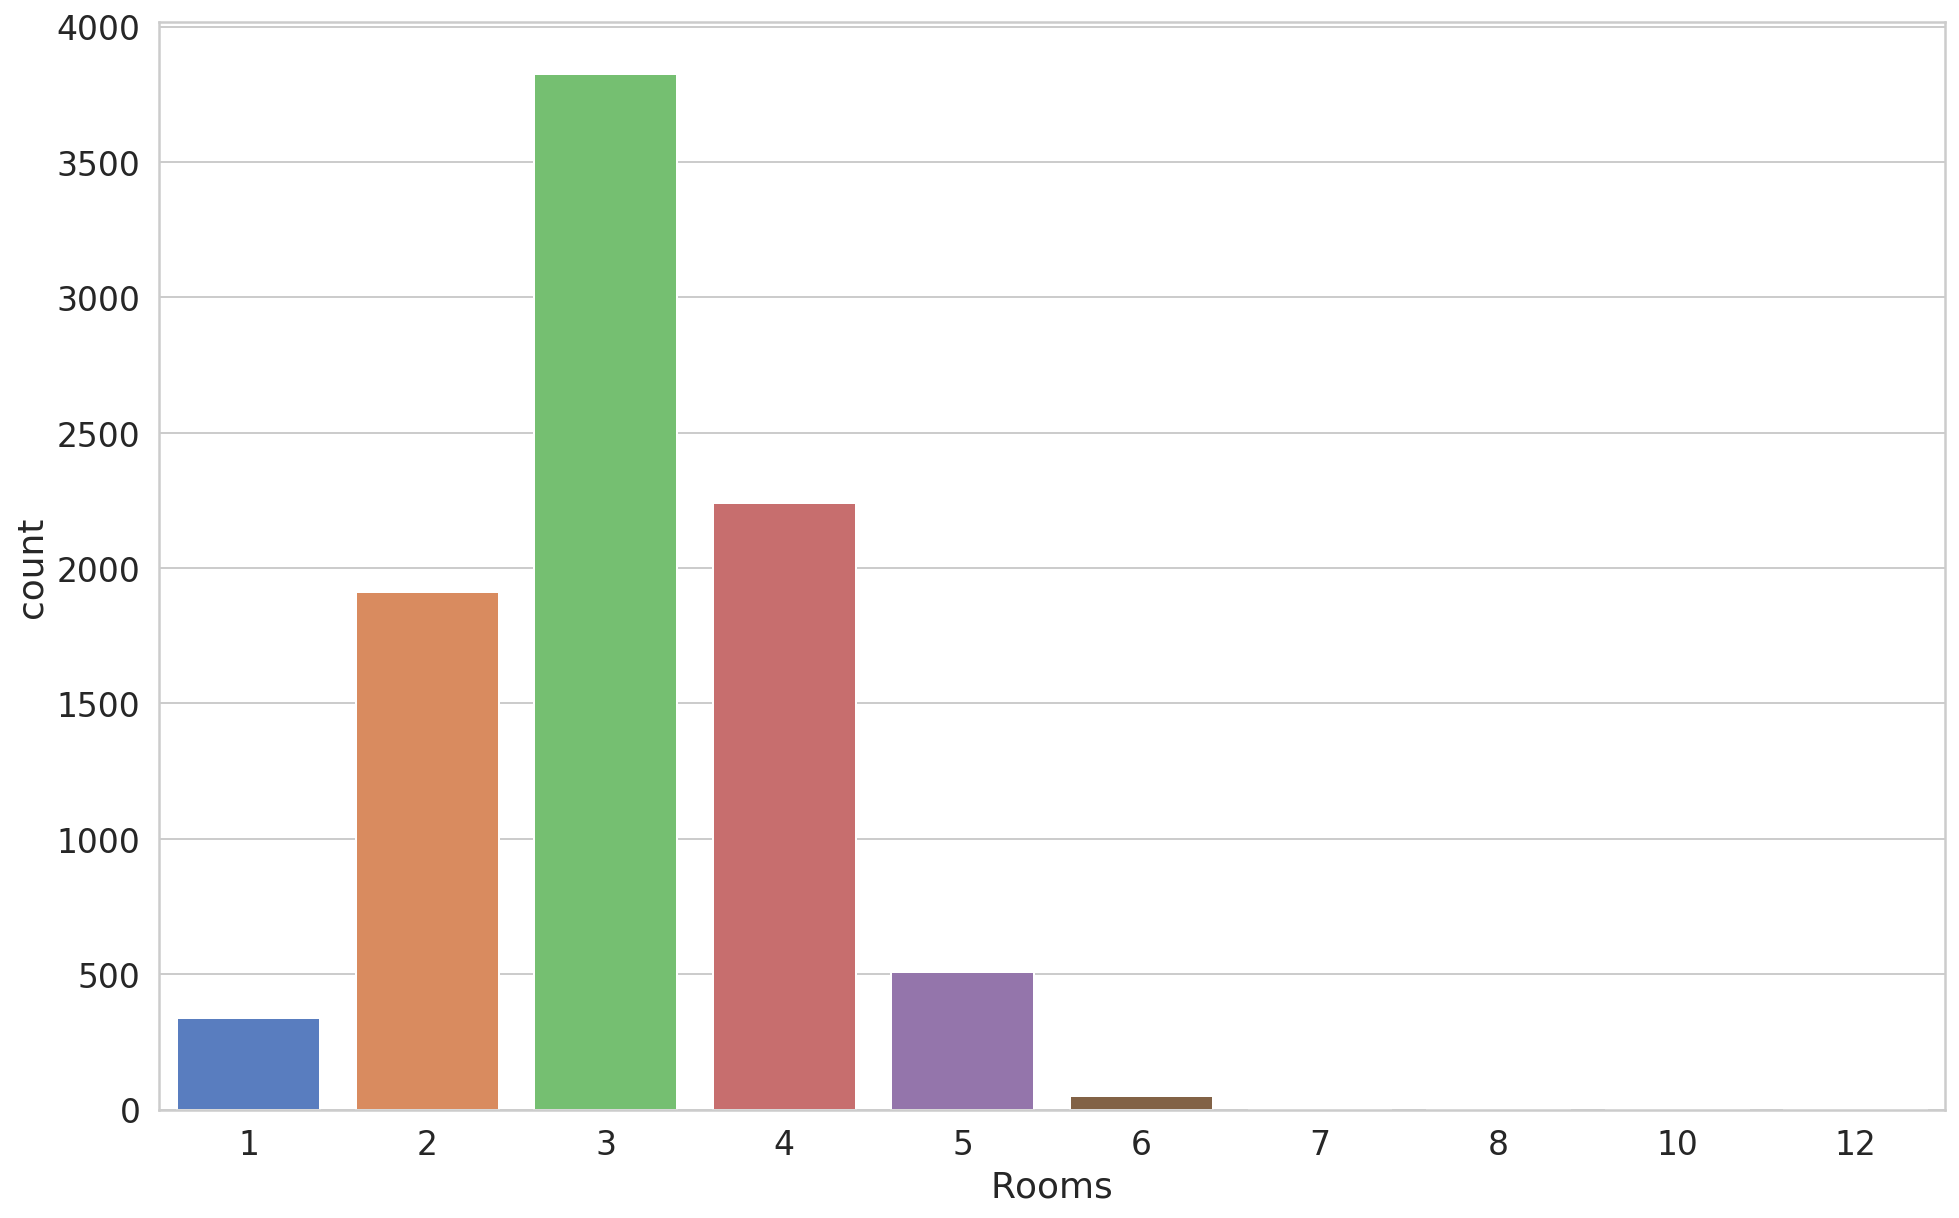

In [0]:
sns.countplot(df.Rooms);

## Baseline Model

In [0]:
X = df[['Rooms', 'Distance', 'Propertycount', 'Postcode', 'Lattitude', 'Longtitude']]
y = np.log1p(df.Price.values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

from sklearn.ensemble import GradientBoostingRegressor

base_model = GradientBoostingRegressor(learning_rate=0.3, n_estimators=150, random_state=RANDOM_SEED).fit(X_train, y_train)

base_model.score(X_test, y_test)

0.7668970798114849

In [0]:
y_base_pred = base_model.predict(X_test)

## Data Transformation

In [0]:
df['Size'] = pd.cut(df.Rooms, bins=[0, 2, 4, 100], labels=["Small", "Medium", "Large"])

In [0]:
df = df.drop(['Address', 'Date'], axis=1)

In [0]:
X = df.drop('Price', axis=1)
y = np.log1p(df.Price.values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [0]:
from sklearn.compose import make_column_transformer

In [0]:
transformer = make_column_transformer(    
    (RobustScaler(), ['Distance', 'Propertycount', 'Postcode', 'Lattitude', 'Longtitude', 'Rooms']),
    (OneHotEncoder(handle_unknown="ignore"), ['Size', 'SaleDayOfWeek', 'Type', 'Method', 'Regionname']),
    (OrdinalEncoder(
        categories=[X.CouncilArea.unique(), X.SellerG.unique(), X.Suburb.unique()], 
        dtype=np.int32
      ), ['CouncilArea', 'SellerG', 'Suburb']
    ),
)

In [0]:
transformer.fit(X_train)

X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

In [0]:
X.shape

(8887, 20)

## Final Model

In [0]:
from sklearn.ensemble import GradientBoostingRegressor

final_model = GradientBoostingRegressor(learning_rate=0.3, n_estimators=150, random_state=RANDOM_SEED).fit(X_train, y_train)
final_model.score(X_test, y_test)

0.8393772235062138

In [0]:
y_final_pred = final_model.predict(X_test)

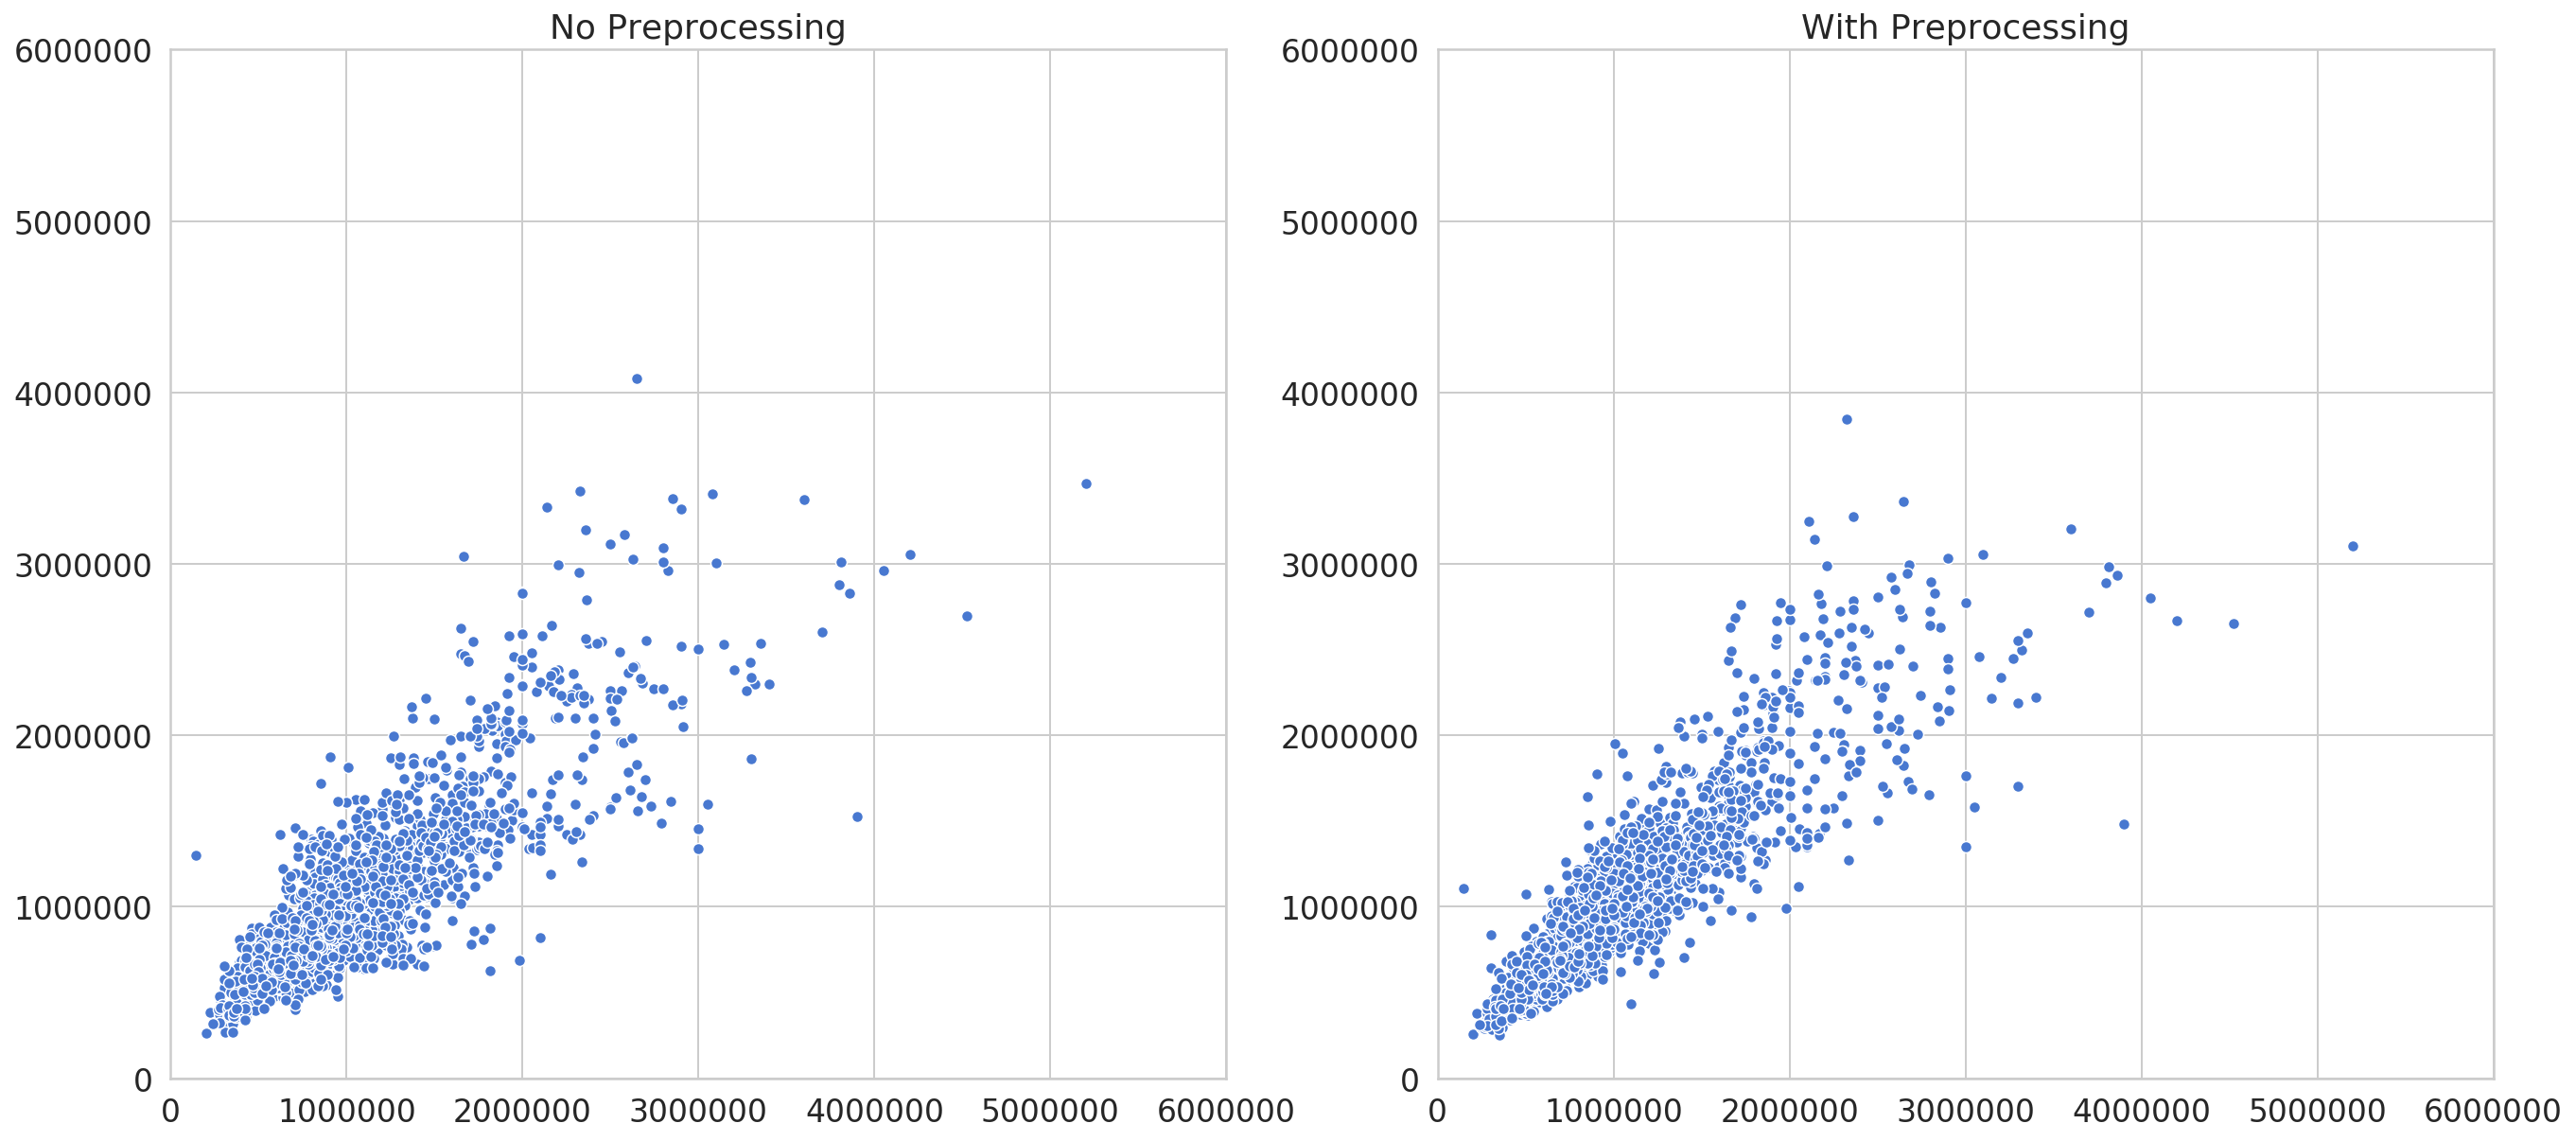

In [0]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(22, 10))

ax1.set_xlim((0, 6000000))
ax1.set_ylim((0, 6000000))
ax1.set_title('No Preprocessing')
sns.scatterplot(np.expm1(y_test), np.expm1(y_base_pred), ax=ax1)

ax2.set_xlim((0, 6000000))
ax2.set_ylim((0, 6000000))
ax2.set_title('With Preprocessing')
sns.scatterplot(np.expm1(y_test), np.expm1(y_final_pred), ax=ax2);